In [28]:
# Gurobi Optimization
import gurobipy as gp
from gurobipy import GRB

def gurobi_minimax(X_leaf, y_leaf):
    """
    Minimax regression (multi-output) with squared L2 error.
    Minimize h s.t. for every sample i: sum_k (m0_k + M_k·x_i - y_{ik})^2 <= h
    Returns: M (m x d), m0 (m,), h (float)
    """
    # Shapes
    n, d = X_leaf.shape
    if y_leaf.ndim == 1:
        y_leaf = y_leaf.reshape(-1, 1)
    m = y_leaf.shape[1]

    try:
        model = gp.Model("minimax_regression")
        model.Params.OutputFlag = 0  # silent

        # Decision variables
        M = model.addVars(m, d, lb=-GRB.INFINITY, name="M")
        m0 = model.addVars(m, lb=-GRB.INFINITY, name="m0")
        h  = model.addVar(lb=0.0, name="h")

        # Quadratic constraints: for each sample i, sum_k (affine)^2 <= h
        for i in range(n):
            quad_terms = []
            for k in range(m):
                # expr = m0[k] + sum_j M[k,j] * X[i,j] - y[i,k]
                expr = m0[k]
                for j in range(d):
                    expr += M[k, j] * float(X_leaf[i, j])  # X is data (constant)
                expr -= float(y_leaf[i, k])
                quad_terms.append(expr * expr)  # (affine)^2 -> QuadExpr

            # Move h to LHS so all quadratic stays on LHS
            model.addQConstr(gp.quicksum(quad_terms) - h <= 0.0)

        # Objective: minimize h
        model.setObjective(h, GRB.MINIMIZE)
        model.optimize()

        if model.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL) or model.SolCount > 0:
            M_val  = np.array([[M[k, j].X for j in range(d)] for k in range(m)])
            m0_val = np.array([m0[k].X for k in range(m)])
            h_val  = float(h.X)
            return M_val, m0_val, h_val
        else:
            return None, None, np.inf

    except gp.GurobiError as e:
        # License-size fallback or other Gurobi errors
        if "Model too large for size-limited license" in str(e):
            # Define this in your codebase
            # return cvxpy_minimax(X_leaf, y_leaf)
            return None, None, np.inf
        raise


In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import copy

In [34]:
class CustomTreeNode:
    """
    Custom tree node for multivariate regression
    """
    def __init__(
        self,
        node_id,
        is_leaf,
        value,
        feature=None,
        threshold=None,
        impurity=None,
        n_samples=None,
    ):
        self.node_id = node_id
        self.is_leaf = is_leaf
        self.value = value              # ndarray (n_targets,)
        self.feature = feature
        self.threshold = threshold
        self.impurity = impurity
        self.n_samples = n_samples
        self.sample_indices = []
        self.left_child = None
        self.right_child = None
        self.parent = None
        self.depth = 0

        self.h=None
        self.M=None
        self.M_0=None

    def __repr__(self):
        if self.is_leaf:
            return (
                f"Leaf(id={self.node_id}, "
                f"value={np.round(self.value, 3)}, "
                f"samples={self.n_samples})"
            )
        return (
            f"Node(id={self.node_id}, "
            f"feature={self.feature}, "
            f"threshold={self.threshold:.3f}, "
            f"samples={self.n_samples})"
        )


In [35]:
class CustomDecisionTree:
    def __init__(self):
        self.root = None
        self.nodes = {}
        self.max_depth = 0

    def add_node(self, node):
        self.nodes[node.node_id] = node
        if node.parent is None:
            self.root = node
            node.depth = 0
        else:
            node.depth = node.parent.depth + 1
            self.max_depth = max(self.max_depth, node.depth)

    def get_leaves(self):
        return [n for n in self.nodes.values() if n.is_leaf]

    def num_nodes(self):
        return len(self.nodes)

    def num_leaves(self):
        return sum(1 for n in self.nodes.values() if n.is_leaf)

    def get_subtree_nodes(self, node):
        stack = [node]
        subtree = []
        while stack:
            current = stack.pop()
            subtree.append(current)
            if not current.is_leaf:
                stack.append(current.right_child)
                stack.append(current.left_child)
        return subtree

    def print_tree(self, node=None, indent=0):
        if node is None:
            node = self.root
        print("  " * indent + str(node))
        if not node.is_leaf:
            self.print_tree(node.left_child, indent + 1)
            self.print_tree(node.right_child, indent + 1)


In [43]:
def sklearn_tree_to_custom_tree(model: DecisionTreeRegressor, X) -> CustomDecisionTree:
    tree = model.tree_
    custom_tree = CustomDecisionTree()
    node_map = {}

    # Create nodes
    for i in range(tree.node_count):
        is_leaf = tree.children_left[i] == -1
        node = CustomTreeNode(
            node_id=i,
            is_leaf=is_leaf,
            value=tree.value[i][0].copy(),
            feature=None if is_leaf else tree.feature[i],
            threshold=None if is_leaf else tree.threshold[i],
            impurity=tree.impurity[i],
            n_samples=tree.n_node_samples[i]
        )
        node_map[i] = node
        custom_tree.nodes[i] = node

    # Link nodes
    for i in range(tree.node_count):
        node = node_map[i]
        if not node.is_leaf:
            left = node_map[tree.children_left[i]]
            right = node_map[tree.children_right[i]]

            node.left_child = left
            node.right_child = right
            left.parent = node
            right.parent = node

    # Assign root
    custom_tree.root = node_map[0]

    # Compute depths correctly
    def assign_depths(node, depth=0):
        node.depth = depth
        custom_tree.max_depth = max(custom_tree.max_depth, depth)
        if not node.is_leaf:
            assign_depths(node.left_child, depth + 1)
            assign_depths(node.right_child, depth + 1)

    assign_depths(custom_tree.root)

    #  Assigning the samples to nodes
    node_indicator = model.decision_path(X)

    for node_id, node in custom_tree.nodes.items():
        mask = node_indicator[:, node_id].toarray().ravel().astype(bool)
        node.sample_indices = np.where(mask)[0]

    return custom_tree


In [145]:
X, y = make_regression(
    n_samples=1000,
    n_features=6,
    n_targets=2,          # multivariate regression
    noise=15.0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


dt = DecisionTreeRegressor(
    max_depth=8,          # intentionally deep
    min_samples_leaf=1,
    random_state=42
)

dt.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=8, random_state=42)

In [146]:
custom_tree = sklearn_tree_to_custom_tree(dt, X_train)


In [147]:
print(f"Number of Nodes = {custom_tree.num_nodes()}\nNumber of Leaves = {custom_tree.num_leaves()}")

Number of Nodes = 375
Number of Leaves = 188


In [148]:

# leaves = custom_tree.get_leaves()
# for leaf in leaves:
#     M_val, m0_val, h_val = gurobi_minimax(X_train[leaf.sample_indices], y_train[leaf.sample_indices])
#     leaf.h = h_val
#     leaf.M = M_val
#     leaf.M_0 = m0_val

# Testing Pruning

In [149]:
def get_subtree_leaves(node):
    if node.is_leaf:
        return [node]

    leaves = []
    stack = [node]
    while stack:
        n = stack.pop()
        if n.is_leaf:
            leaves.append(n)
        else:
            stack.append(n.left_child)
            stack.append(n.right_child)
    return leaves


def remove_subtree(tree, node):
    """Remove node and all descendants from tree.nodes"""
    for n in tree.get_subtree_nodes(node):
        if n.node_id in tree.nodes:
            del tree.nodes[n.node_id]


In [150]:
def leaf_cost(node):
    """
    Example data-fit cost using h.
    Replace with your real objective.
    """
    return node.h


def subtree_cost(node):
    return sum(leaf_cost(l) for l in get_subtree_leaves(node))


In [134]:
def collapse_to_leaf(tree, node, X, y):
    """
    Prune children and re-optimize node as leaf.
    """

    # remove children from tree registry
    remove_subtree(tree, node.left_child)
    remove_subtree(tree, node.right_child)

    # detach
    node.left_child = None
    node.right_child = None

    node.is_leaf = True
    node.feature = None
    node.threshold = None

    # re-run optimization on merged samples
    M_val, m0_val, h_val = gurobi_minimax(
        X[node.sample_indices],
        y[node.sample_indices]
    )

    node.M = M_val
    node.M_0 = m0_val
    node.h = h_val


In [135]:
def bottom_up_prune(tree, X, y, alpha):
    """
    CART-style complexity pruning:

        cost(subtree)  vs  cost(node_as_leaf) + alpha

    Iterates bottom-up until no change.
    """

    changed = True

    while changed:
        changed = False

        # deepest first
        internal_nodes = sorted(
            [n for n in tree.nodes.values() if not n.is_leaf],
            key=lambda n: n.depth,
            reverse=True,
        )

        for node in internal_nodes:

            if node.left_child is None:
                continue

            # --- cost if keep subtree ---
            keep_cost = subtree_cost(node)

            # --- cost if collapse ---
            M_val, m0_val, h_val = gurobi_minimax(
                X[node.sample_indices],
                y[node.sample_indices]
            )

            collapse_cost = h_val # + alpha

            # --- decision ---
            if collapse_cost <= keep_cost:

                collapse_to_leaf(tree, node, X, y)

                changed = True
                break     # restart scan after modification


# Usage Example

In [136]:
# optimize original leaves
for leaf in custom_tree.get_leaves():
    M_val, m0_val, h_val = gurobi_minimax(
        X_train[leaf.sample_indices],
        y_train[leaf.sample_indices],
    )

    leaf.h = h_val
    leaf.M = M_val
    leaf.M_0 = m0_val


print("BEFORE")
print("nodes :", custom_tree.num_nodes())
print("leaves:", custom_tree.num_leaves())
print("depth :", custom_tree.max_depth)





BEFORE
nodes : 375
leaves: 188
depth : 8


In [137]:
bottom_up_prune(custom_tree, X_train, y_train, alpha=1)


print("\nAFTER")
print("nodes :", custom_tree.num_nodes())
print("leaves:", custom_tree.num_leaves())
print("depth :", custom_tree.max_depth)


AFTER
nodes : 1
leaves: 1
depth : 8


In [138]:
custom_tree.get_leaves()[0].h

2236.4592892016008

# Graphically showing the tree

In [151]:
import matplotlib.pyplot as plt
import networkx as nx


def visualize_custom_tree(tree: CustomDecisionTree, figsize=(18, 10)):
    """
    Draw the custom decision tree using networkx + matplotlib.
    """

    G = nx.DiGraph()

    labels = {}

    # build graph
    for node in tree.nodes.values():

        if node.is_leaf:
            label = (
                f"Leaf {node.node_id}\n"
                f"samples={len(node.sample_indices)}\n"
                f"h={round(node.h, 3) if node.h is not None else None}"
            )
        else:
            label = (
                f"Node {node.node_id}\n"
                f"X[{node.feature}] <= {round(node.threshold, 3)}\n"
                f"samples={len(node.sample_indices)}"
            )

        labels[node.node_id] = label

        if node.left_child is not None:
            G.add_edge(node.node_id, node.left_child.node_id)

        if node.right_child is not None:
            G.add_edge(node.node_id, node.right_child.node_id)

    # hierarchical layout
    pos = hierarchy_pos(G, tree.root.node_id)

    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        labels=labels,
        with_labels=True,
        node_size=2200,
        node_color="lightgray",
        font_size=8,
    )

    plt.title("Custom Decision Tree")
    plt.show()

def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    """
    Recursively compute node positions for a tree layout.
    """

    def _hierarchy_pos(G, root, left, right, vert_loc, pos):

        pos[root] = ((left + right) / 2, vert_loc)

        children = list(G.successors(root))
        if len(children) == 0:
            return pos

        dx = (right - left) / len(children)

        nextx = left
        for child in children:
            pos = _hierarchy_pos(
                G,
                child,
                nextx,
                nextx + dx,
                vert_loc - vert_gap,
                pos,
            )
            nextx += dx

        return pos

    return _hierarchy_pos(G, root, 0, width, vert_loc, {})

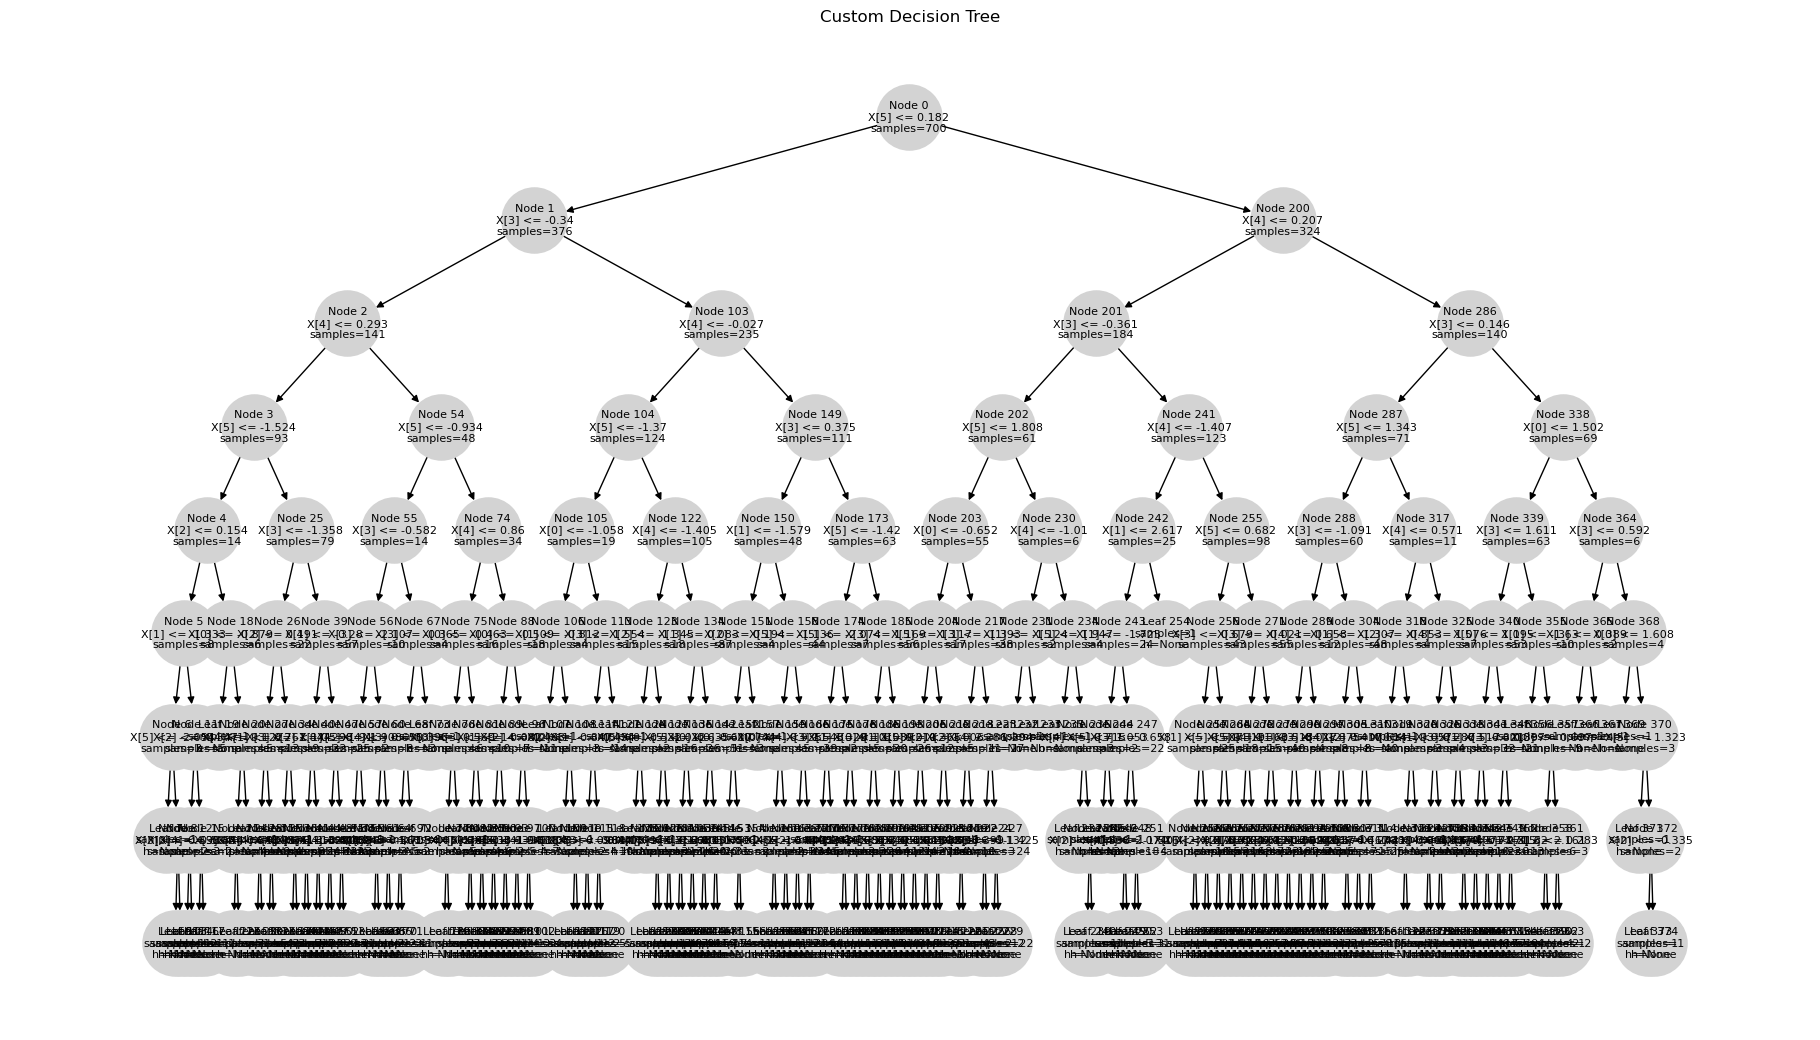

In [152]:
visualize_custom_tree(custom_tree)


with visualization, we can:

👉 overlay pruned nodes
👉 color pruned vs kept
👉 animate pruning
👉 show α-paths
👉 interactive pruning
👉 draw cost values
👉 highlight subtree collapse